In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
month="02"
coverage_threshold = 0.40

subtype_year2result = dict()

for subtype in ("h3n2", "h1n1"):
    year2result = dict()
    for year in range(2012, 2021):
#         vaccine_scores_path = "../../results/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
        if not os.path.exists(vaccine_scores_path):
            continue
        for file in os.listdir(vaccine_scores_path):
            if file == "prob=lightning_logs_version_0___hi=max_steps_150k":
#             if file == "prob=lightning_logs_version_0___hi=lightning_logs_version_0":
                if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                    our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                    year2result[year] = our_model

    subtype_year2result[subtype] = year2result

In [3]:
subtype_time2vaccine_strains = dict()
subtype_time2ve = dict()
for subtype in ("h3n2", "h1n1"):
    ve_path = "../../data/vaccine_effectiveness/ve_%s.csv" % subtype
    ve = pd.read_csv(ve_path)
    ve["time_bin"] = [int(year.split("-")[0]) - 2018 + 30 for year in ve["Year"]]
    ve["vaccine effectiveness"] = [x if isinstance(x, float) else float(x[:-1]) for x in ve["VE"].to_numpy()]
    ve["subtype"] = [subtype] * len(ve)
#     print(ve)

    time2vaccine_strains = dict()
    time2ve = dict()

    for strains, year, eff in zip(ve["Strain"], ve["Year"], ve["vaccine effectiveness"]):
        year = int(year.split("-")[0]) # 2018
        time2vaccine_strains[year] = strains.split("|")
        time2ve[year] = eff
    subtype_time2vaccine_strains[subtype] = time2vaccine_strains
    subtype_time2ve[subtype] = time2ve

In [4]:

ref_vaccine_scores = []
ref_ve = []
ref_source = []
ref_subtype = []

for subtype in ("h3n2", "h1n1"):
    
    year2result = subtype_year2result[subtype]
    time2vaccine_strains = subtype_time2vaccine_strains[subtype]
    time2ve = subtype_time2ve[subtype]

    for year in time2vaccine_strains:
        if year not in year2result:
            continue
        vaccine_strains = time2vaccine_strains[year]
        effectiveness = time2ve[year]
        if isinstance(effectiveness, float) and not np.isnan(effectiveness):
            ref_vaccine_score_pred = []
            ref_vaccine_score_gt = []
            for gt_score, score, name, coverage in zip(year2result[year]["gt_score_seq"], year2result[year]["score"], year2result[year]["strain_name"], year2result[year]["coverage_seq"]):
                if coverage < coverage_threshold:
                    continue
                if not isinstance(name, str):
                    continue
                for vaccine_strain in vaccine_strains:
                    if vaccine_strain.replace(" ", "_") in name:
                        ref_vaccine_score_pred.append(score)
                        ref_vaccine_score_gt.append(gt_score)
                        break

            if len(ref_vaccine_score_pred) > 0:
                ref_vaccine_score = [x  for x in ref_vaccine_score_pred if not np.isnan(x)]
                if len(ref_vaccine_score) > 0:
                    ref_vaccine_scores.append(np.median(ref_vaccine_score_pred))
                    ref_ve.append(effectiveness)
                    ref_source.append("Prediction")
                    ref_subtype.append(subtype)

                ref_vaccine_score_gt = [x  for x in ref_vaccine_score_gt if not np.isnan(x)]
                if len(ref_vaccine_score_gt) > 0:
                    ref_vaccine_scores.append(sum(ref_vaccine_score_gt) / len(ref_vaccine_score_gt))
                    ref_ve.append(effectiveness)
                    ref_source.append("Ground-truth")
                    ref_subtype.append(subtype)


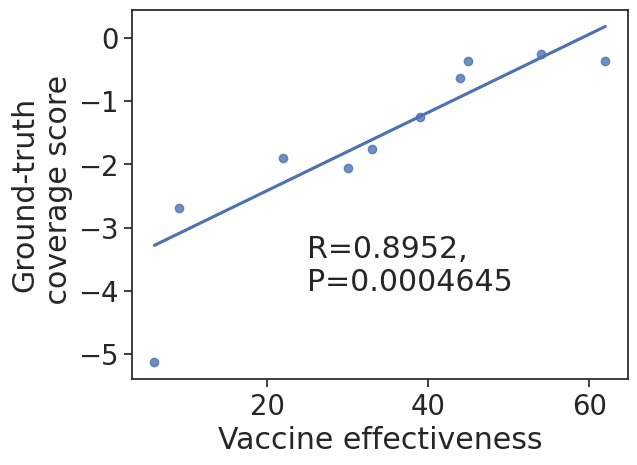

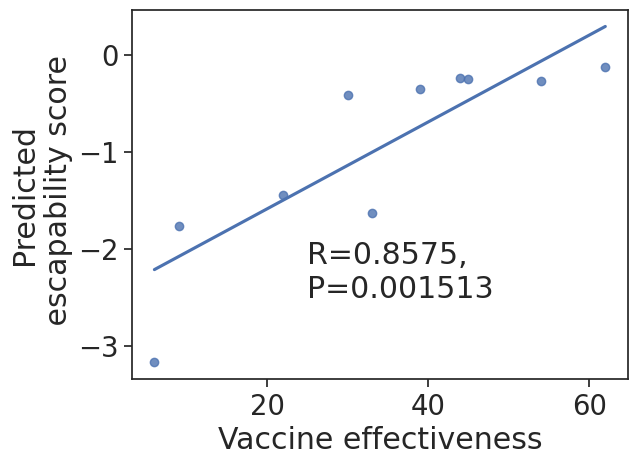

In [5]:


ref_vaccine_scores = np.asarray(ref_vaccine_scores)

d = {'vaccine effectiveness': ref_ve, 
     'escapability score': - ref_vaccine_scores, 
     'subtype': ["A/%s" % x.upper() for x in ref_subtype], '': ref_source}
res = pd.DataFrame(data=d)

# print(res)

sns.set(font_scale=1.8, style="ticks")

gt_spearman_rank, gt_pvalue = stats.spearmanr(res[res[""] == "Ground-truth"]["escapability score"], res[res[""] == "Ground-truth"]["vaccine effectiveness"])
gt_pearsonr, gt_pvalue_pearson = stats.pearsonr(res[res[""] == "Ground-truth"]["escapability score"], res[res[""] == "Ground-truth"]["vaccine effectiveness"])

pred_spearman_rank, pred_pvalue = stats.spearmanr(res[res[""] == "Prediction"]["escapability score"], res[res[""] == "Prediction"]["vaccine effectiveness"])
pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(res[res[""] == "Prediction"]["escapability score"], res[res[""] == "Prediction"]["vaccine effectiveness"])


# Ground-truth score & VE
ax = sns.regplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res[res[""] == "Ground-truth"], robust=True, ci=None) # ci = 95) # , ci=95
ax.text(25, -4.0, "R=%.4lf, \nP=%.4g" % (gt_pearsonr, gt_pvalue_pearson))
ax.set_ylabel("Ground-truth\n coverage score")
ax.set_xlabel("Vaccine effectiveness")

gt_fitline_ys = ax.get_lines()[0].get_ydata()
gt_fitline_xs = ax.get_lines()[0].get_xdata()

# plt.savefig("figs/ve_%s_gt.pdf" % subtype, format='pdf', bbox_inches='tight')
plt.show()


# Predicted scores & VE
ax = sns.regplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res[res[""] == "Prediction"], robust=True, ci=None) # ci = 95) # , ci=95
ax.text(25, -2.5, "R=%.4lf, \nP=%.4g" % (pred_pearsonr, pred_pvalue_pearson))

ax.set_ylabel("Predicted\n escapability score")
ax.set_xlabel("Vaccine effectiveness")

pred_fitline_ys = ax.get_lines()[0].get_ydata()
pred_fitline_xs = ax.get_lines()[0].get_xdata()

# plt.savefig("figs/ve_%s_predicted.pdf" % subtype, format='pdf', bbox_inches='tight')
plt.show()

0.06182034846192541
0.044755227122150514


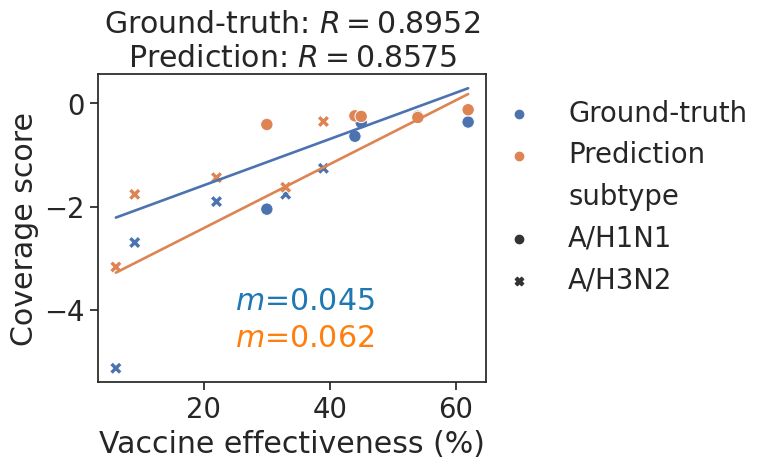

In [7]:

# combine

res = res.sort_values(by=[''])
res = res.sort_values(by=['subtype'])

fig, ax = plt.subplots(figsize=(5, 4))

ax = sns.scatterplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res, hue="", style="subtype", s=80, ax=ax) # ci = 95) # , ci=95

ax = sns.lineplot(y = pred_fitline_ys, x = pred_fitline_xs,linewidth=1.9) # ci = 95) # , ci=95
ax = sns.lineplot(y = gt_fitline_ys, x = gt_fitline_xs,linewidth=1.9) # ci = 95) # , ci=95

print(((gt_fitline_ys[1:] - gt_fitline_ys[:-1]) / (gt_fitline_xs[1:] - gt_fitline_xs[:-1]))[0])
print(((pred_fitline_ys[1:] - pred_fitline_ys[:-1]) / (pred_fitline_xs[1:] - pred_fitline_xs[:-1]))[0])

slope_gt = ((gt_fitline_ys[1:] - gt_fitline_ys[:-1]) / (gt_fitline_xs[1:] - gt_fitline_xs[:-1]))[0]
slope_pred = ((pred_fitline_ys[1:] - pred_fitline_ys[:-1]) / (pred_fitline_xs[1:] - pred_fitline_xs[:-1]))[0]
ax.text(25,-4.0, "$m$=%.3lf" % (slope_pred), color="#1f77b4")
ax.text(25,-4.7, "$m$=%.3lf" % (slope_gt), color="#ff7f0e")


ax.legend(frameon=False)

ax.set_title(f"Ground-truth: $R=%.4lf$\nPrediction: $R=%.4lf$" % (gt_pearsonr, pred_pearsonr))
ax.set_ylabel("Coverage score")
ax.set_xlabel("Vaccine effectiveness (%)")

sns.move_legend(ax, "upper left", bbox_to_anchor=(0.95, 1))

plt.savefig("figs/ve_overall_new.pdf", format='pdf', bbox_inches='tight')
plt.show()